In [1]:
%matplotlib inline
import h2o
import xgboost
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sfrom sklearn.feature_selection import SelectFromModelns
import matplotlib as mpl
import statsmodels.api as sm
import matplotlib.pylab as plt
from sklearn.svm import SVC
from sklearn.metrics import *
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from h2o.estimators.random_forest import H2ORandomForestEstimator
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 50)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# DSS TEAM PROJECTS ( 2 ) - MACHINE LEARNING

# Main Project
### [Predicting Red Hat Business Value](https://www.kaggle.com/c/predicting-red-hat-business-value)
- Classify customer potential
![](https://kaggle2.blob.core.windows.net/competitions/kaggle/5261/media/kaggle-image_072516_1269x351.jpg)

Like most companies, Red Hat is able to gather a great deal of information over time about the behavior of individuals who interact with them. They’re in search of better methods of using this behavioral data to predict which individuals they should approach—and even when and how to approach them.

In this competition, Kagglers are challenged to create a classification algorithm that accurately identifies which customers have the most potential business value for Red Hat based on their characteristics and activities.

With an improved prediction model in place, Red Hat will be able to more efficiently prioritize resources to generate more business and better serve their customers.


# Function

In [2]:
def str_to_num(df, train=True, activity_id = True):
    col_list = list(df)
    col_list.remove('date_x')
    col_list.remove('date_y')
    if train:
        col_list.remove('outcome')
        
    for col in col_list[:col_list.index('char_9_y')+1]:
        if col == 'activity_id':
            if activity_id == True:
                df.loc[:,col] = df.loc[:,col].apply(lambda x: x.split('_')[0])
                df.replace('act', '', regex=True, inplace = True)
        elif col == 'people_id':
            df.loc[:,col] = df.loc[:,col].apply(lambda x: x.split('_')[1])
        else :
            df.loc[:,col][df.loc[:,col].isnull()==False] = df.loc[:,col][df.loc[:,col].isnull()==False].apply(lambda x: x.split(' ')[1])
        df.loc[:, col] = pd.to_numeric(df.loc[:, col][df.loc[:,col].isnull()==False]).astype(int)
            
    for col in col_list[col_list.index('char_10_y'):col_list.index('char_38')+1]:
        df.loc[:,col] = df.loc[:,col].replace({True:1, False:0})
        
    return df

In [3]:
def date_modify(df):
    df.insert(loc=list(df).index('date_x')+1 ,column='week_x', value=df['date_x'].dt.weekday)
    df.insert(loc=list(df).index('date_y')+1 ,column='week_y', value=df['date_y'].dt.weekday)
    df.insert(loc=list(df).index('week_x')+1 ,column='Past_days', value=(df.date_x - df.date_y).astype('timedelta64[D]'))
    df['days']=(pd.to_numeric(df.date_x)//86400000000000) - (pd.to_numeric(df.date_x)//86400000000000).min()
    return df

In [4]:
def add_bool_sum(df):
    temp = df.copy()
    temp['bool_sum'] = temp.iloc[:,list(temp).index('char_10_y'):list(temp).index('char_37')].sum(axis=1)
    return temp

In [6]:
def one_hot_encoder(df, columns):
    temp = df.copy()
    for col in columns:
        for i in list(pd.get_dummies(temp[col]))[-1::-1]:    
            temp.insert(loc=list(temp).index(col)+1 ,column=col+str(i), value=pd.get_dummies(temp.loc[:,col]).loc[:,i])
        temp = temp.drop([col], axis=1)
    return temp

In [7]:
import io
import pydot
from IPython.core.display import Image 
from sklearn.tree import export_graphviz

# 강사님 함수
def draw_decision_tree(model, feature_names):
    dot_buf = io.StringIO() 
    export_graphviz(model, out_file=dot_buf, feature_names=feature_names)
    graph = pydot.graph_from_dot_data(dot_buf.getvalue())[0] 
    image = graph.create_png()
    return Image(image)

# data load & 전처리

### data load

In [251]:
df_train = pd.read_csv('./data/act_train.csv', parse_dates=['date'])
df_people = pd.read_csv('./data/people.csv', parse_dates=['date'])
df_merge = pd.merge(df_train, df_people, on='people_id')

In [252]:
df_test = pd.read_csv('./data/act_test.csv', parse_dates=['date'])
df_merge_test = pd.merge(df_test, df_people, how='inner', on='people_id')

In [253]:
# submissin 만들때 필요함
df_test_act_id = df_merge_test.activity_id.copy()

### 전처리

In [254]:
df_train.head(3)

,people_id,activity_id,date,activity_category,char_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10,outcome
0,ppl_100,act2_1734928,2023-08-26,type 4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 76,0
1,ppl_100,act2_2434093,2022-09-27,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,0
2,ppl_100,act2_3404049,2022-09-27,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,0


#### train
+ people_id
+ activity_id 
+ date_x
+ activity_category
+ char_1_x ~ char_9_x 
+ char_10_x
+ outcome : target!!! 


In [255]:
df_people.head(3)

,people_id,char_1,group_1,char_2,date,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10,char_11,char_12,char_13,char_14,char_15,char_16,char_17,char_18,char_19,char_20,char_21,char_22,char_23,char_24,char_25,char_26,char_27,char_28,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38
0,ppl_100,type 2,group 17304,type 2,2021-06-29,type 5,type 5,type 5,type 3,type 11,type 2,type 2,True,False,False,True,True,False,True,False,False,False,False,True,False,False,False,False,False,True,True,False,True,True,False,False,True,True,True,False,36
1,ppl_100002,type 2,group 8688,type 3,2021-01-06,type 28,type 9,type 5,type 3,type 11,type 2,type 4,False,False,True,True,False,False,False,True,False,False,False,False,False,True,False,True,True,True,False,False,True,True,True,True,True,True,True,False,76
2,ppl_100003,type 2,group 33592,type 3,2022-06-10,type 4,type 8,type 5,type 2,type 5,type 2,type 2,True,True,True,True,True,True,False,True,False,True,False,True,True,True,True,True,True,True,True,False,False,True,True,True,True,False,True,True,99


#### people  
+ char_1_y 
+ group_1
+ char_2_y 
+ date_y
+ char_3_y ~ char_9_y 
+ char_10_y ~ char_37
+ char_38

In [257]:
str_to_num(df_merge, train=True)
date_modify(df_merge)
df_merge = add_bool_sum(df_merge)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [258]:
str_to_num(df_merge_test, train=False)
date_modify(df_merge_test)
df_merge_test = add_bool_sum(df_merge_test)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [260]:
df_merge.head(3)

,people_id,activity_id,date_x,week_x,Past_days,activity_category,char_1_x,char_2_x,char_3_x,char_4_x,char_5_x,char_6_x,char_7_x,char_8_x,char_9_x,char_10_x,outcome,char_1_y,group_1,char_2_y,date_y,week_y,char_3_y,char_4_y,char_5_y,char_6_y,char_7_y,char_8_y,char_9_y,char_10_y,char_11,char_12,char_13,char_14,char_15,char_16,char_17,char_18,char_19,char_20,char_21,char_22,char_23,char_24,char_25,char_26,char_27,char_28,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38,days,bool_sum
0,100,2,2023-08-26,5,788.0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76.0,0,2,17304,2,2021-06-29,1,5,5,5,3,11,2,2,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,1,1,0,0,1,1,1,0,36,405,12
1,100,2,2022-09-27,1,455.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0,2,17304,2,2021-06-29,1,5,5,5,3,11,2,2,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,1,1,0,0,1,1,1,0,36,72,12
2,100,2,2022-09-27,1,455.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0,2,17304,2,2021-06-29,1,5,5,5,3,11,2,2,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,1,1,0,0,1,1,1,0,36,72,12


#### merge
+ week_x, week_y
+ Past_days
+ days 
+ bool_sum 

In [259]:
del df_test, df_people, df_train

#### save data

In [13]:
# df_merge.to_csv("train_merge.csv")
# df_merge_test.to_csv("test_merge.csv")

In [14]:
# df_merge = pd.read_csv('./train_merge.csv', parse_dates=['date_x', 'date_y'])
# df_merge_test = pd.read_csv('./test_merge.csv', parse_dates=['date_x', 'date_y'])

# EDA

In [27]:
df_merge[['date_x', 'date_y']].describe()

,date_x,date_y
count,2197291,2197291
unique,411,1196
top,2022-09-30 00:00:00,2022-03-02 00:00:00
freq,48174,55371
first,2022-07-17 00:00:00,2020-05-18 00:00:00
last,2023-08-31 00:00:00,2023-08-31 00:00:00


In [28]:
pd.DataFrame(df_merge.people_id, dtype='object').describe()

,people_id
count,2197291
unique,151295
top,294918
freq,55103


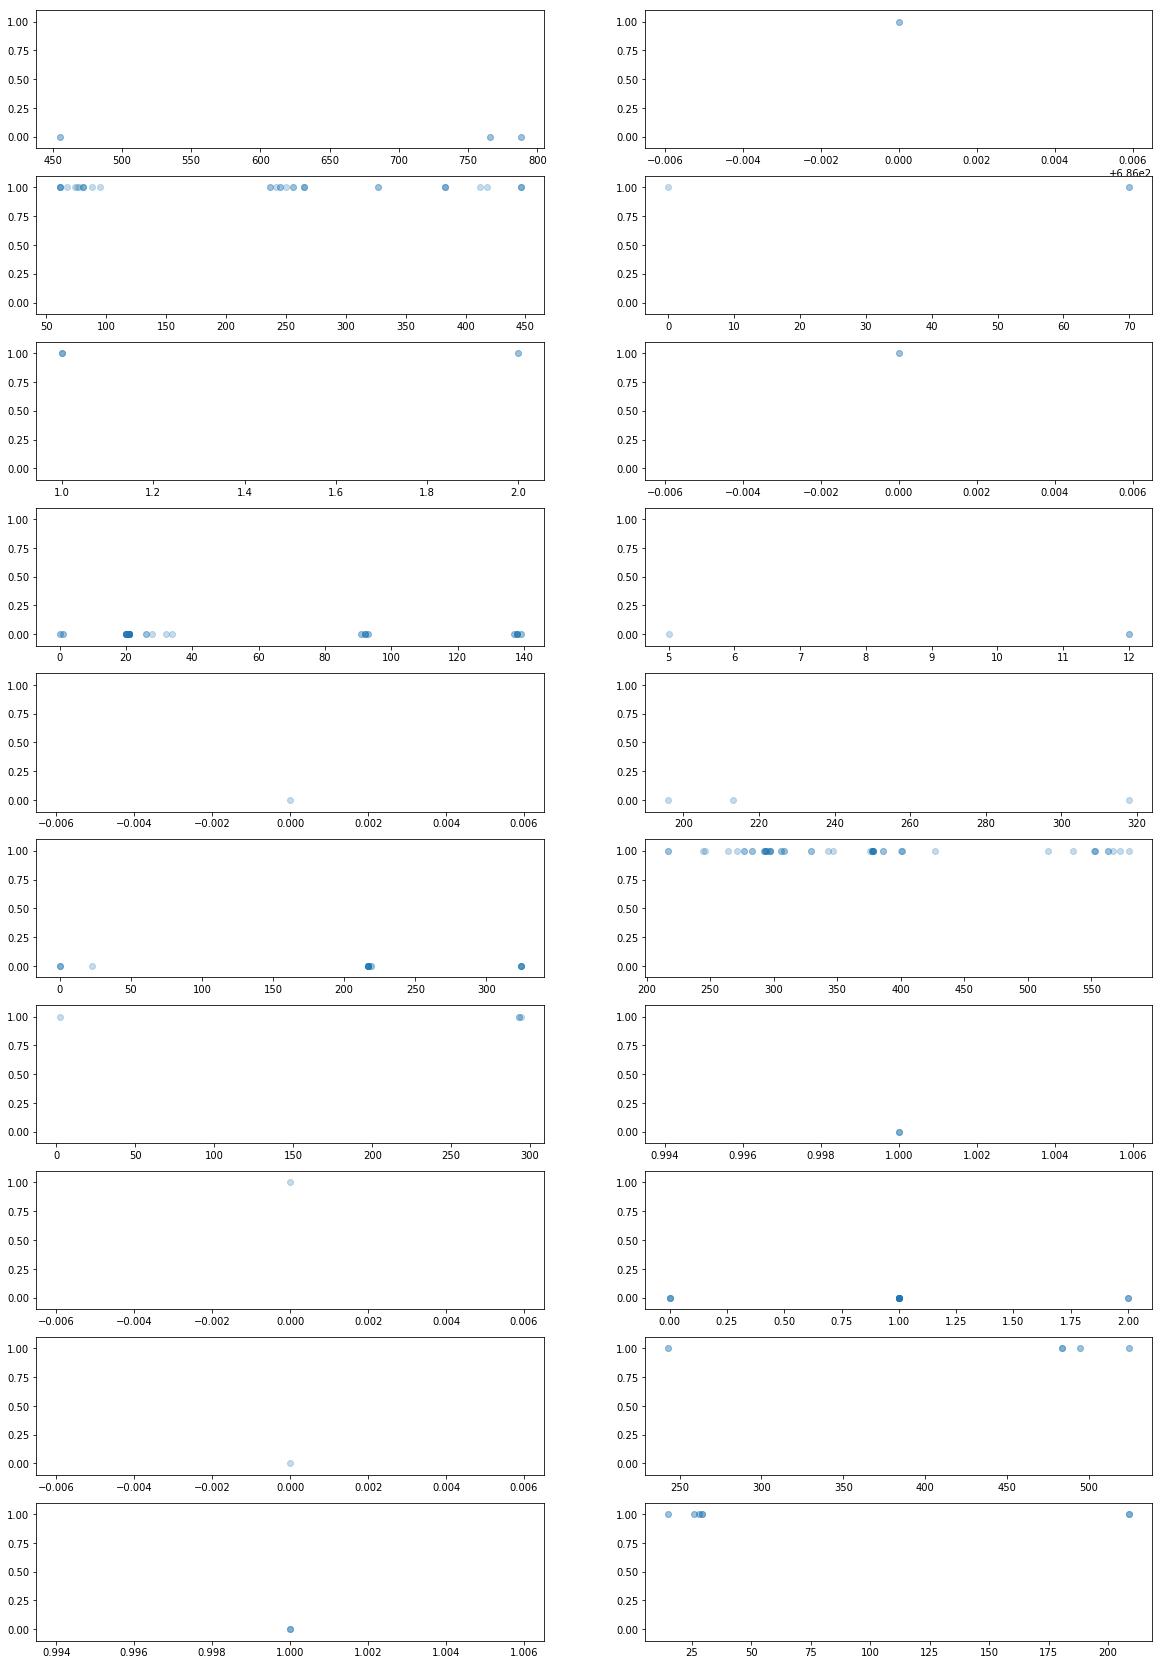

In [30]:
# ppl 별 구매 경향
plt.figore(figsize=(20,30))
for i, ppl in enumerate(df_merge.people_id.unique()[:20]):
    plt.subplot(10,2,i+1)    
    plt.scatter(df_merge[df_merge.people_id == ppl]['Past_days'], \
                df_merge[df_merge.people_id == ppl].outcome, alpha = 0.25) 
    plt.ylim(-0.1,1.1)
plt.show()

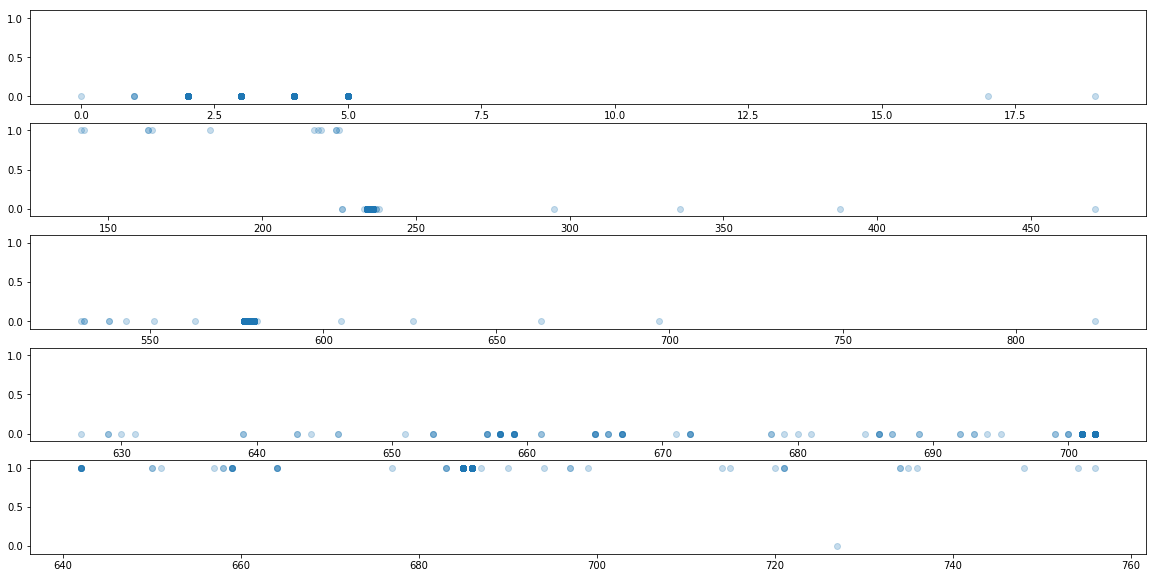

In [32]:
# ppl 별 구매 경향 top 5
plt.figure(figsize=(20,10))
for i, ppl in enumerate([294918, 370270, 105739, 54699, 64887]):
    plt.subplot(5,1,i+1)    
    plt.scatter(df_merge[df_merge.people_id == ppl]['Past_days'], \
                df_merge[df_merge.people_id == ppl].outcome, alpha = 0.25) 
    plt.ylim(-0.1,1.1)
plt.show()

#### sample

In [144]:
df_sample = df_merge.sample(frac = 0.1, random_state=0).copy()
df_sample = add_bool_sum(df_sample)

In [145]:
df_sample2 = df_merge.sample(frac = 0.1, random_state=1).copy()
df_sample2 = add_bool_sum(df_sample2)

In [39]:
df_sample.groupby(['activity_id', 'activity_category']).count()

people_id  date_x  week_x  Past_days  char_1_x  \
activity_id activity_category                                                   
1           1                      15813   15813   15813      15813     15813   
2           2                      90498   90498   90498      90498         0   
            3                      42804   42804   42804      42804         0   
            4                      20891   20891   20891      20891         0   
            5                      48968   48968   48968      48968         0   
            6                        429     429     429        429         0   
            7                        326     326     326        326         0   

                               char_2_x  char_3_x  char_4_x  char_5_x  \
activity_id activity_category                                           
1           1                     15813     15813     15813     15813   
2           2                         0         0         0         0   
            3                         0         0         0         0   
            4                         0         0         0         0   
            5                         0         0         0         0   
            6                         0         0         0         0   
            7                         0         0         0         0   

                               char_6_x  char_7_x  char_8_x  char_9_x  \
activity_id activity_category                                           
1           1                     15813     15813     15813     15813   
2           2                         0         0         0         0   
            3                         0         0         0         0   
            4                         0         0         0         0   
            5                         0         0         0         0   
            6                         0         0         0         0   
            7                         0         0         0         0   

                               char_10_x  outcome  char_1_y  group_1  \
activity_id activity_category                                          
1           1                          0    15813     15813    15813   
2           2                      90498    90498     90498    90498   
            3                      42804    42804     42804    42804   
            4                      20891    20891     20891    20891   
            5                      48968    48968     48968    48968   
            6                        429      429       429      429   
            7                        326      326       326      326   

                               char_2_y  date_y  week_y  char_3_y  char_4_y  \
activity_id activity_category                                                 
1           1                     15813   15813   15813     15813     15813   
2           2                     90498   90498   90498     90498     90498   
            3                     42804   42804   42804     42804     42804   
            4                     20891   20891   20891     20891     20891   
            5                     48968   48968   48968     48968     48968   
            6                       429     429     429       429       429   
            7                       326     326     326       326       326   

                               char_5_y  char_6_y  char_7_y  char_8_y  \
activity_id activity_category                                           
1           1                     15813     15813     15813     15813   
2           2                     90498     90498     90498     90498   
            3                     42804     42804     42804     42804   
            4                     20891     20891     20891     20891   
            5                     48968     48968     48968     48968   
            6                       429       429       429       429   
            7                       326 

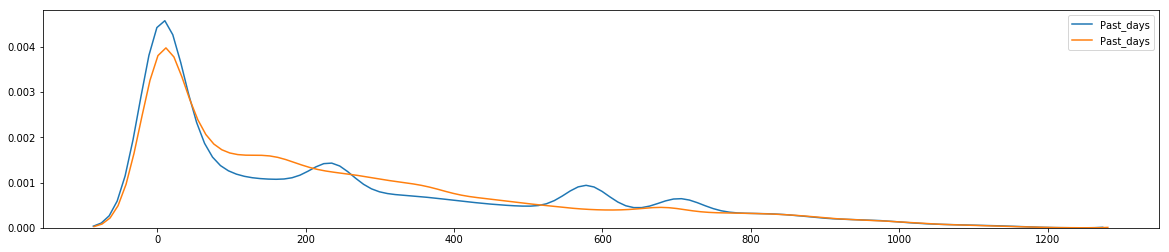

In [262]:
plt.figure(figsize=(20,4))
sns.kdeplot(df_sample[df_sample.outcome==0]['Past_days'])
sns.kdeplot(df_sample[df_sample.outcome==1]['Past_days'])
plt.show()

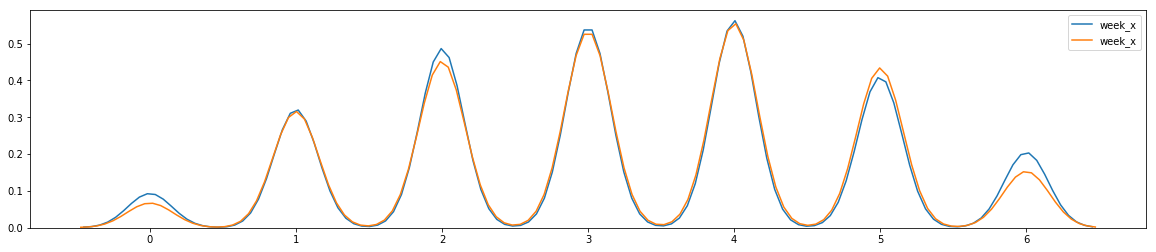

In [41]:
plt.figure(figsize=(20,4))
sns.kdeplot(df_sample[df_sample.outcome==0]['week_x'])
sns.kdeplot(df_sample[df_sample.outcome==1]['week_x'])
plt.show()

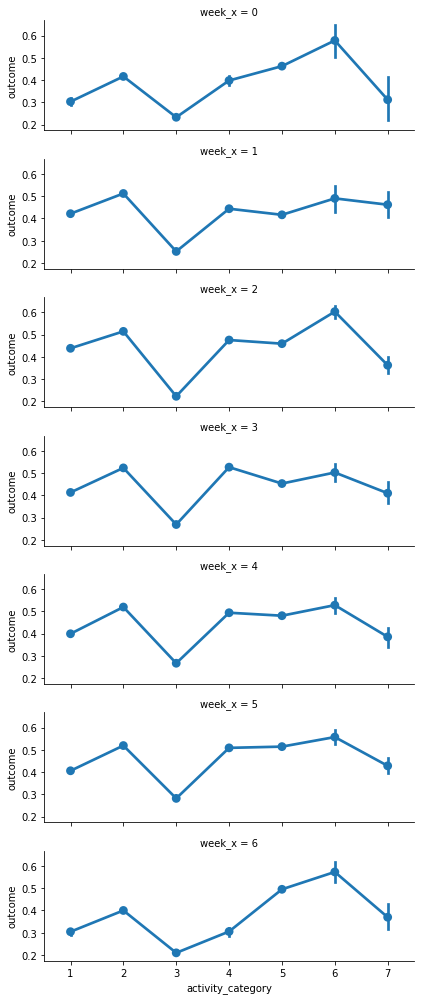

In [263]:
sns.factorplot(x="activity_category", y="outcome", row="week_x", data=df_merge,
               size=2, aspect=3, kind="point")
plt.show()

#### char_1_x ~ char_9_x

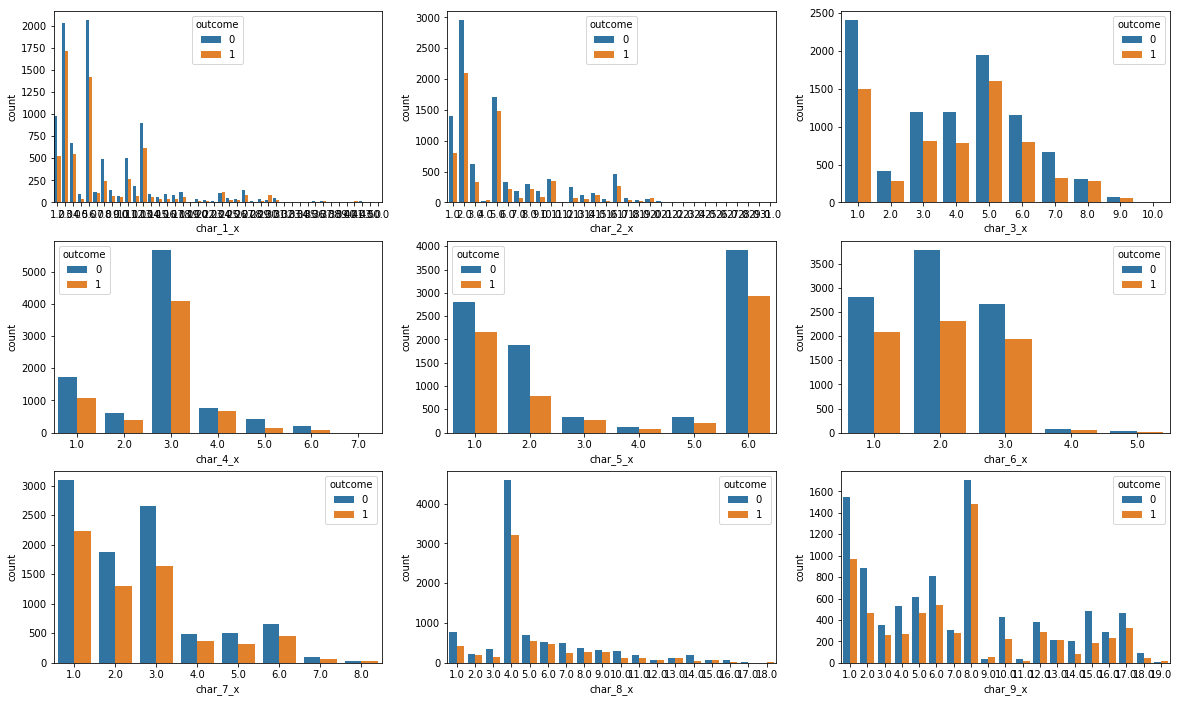

In [42]:
plt.figure(figsize=(20,12))
for i, feat in enumerate(df_sample.columns[list(df_sample).index('char_1_x'):list(df_sample).index('char_9_x')+1]):
    plt.subplot(3,3,i+1)
    sns.countplot(feat, hue='outcome', data=df_sample)
plt.show()

#### char_2_y ~ char_9_y

<function matplotlib.pyplot.show>

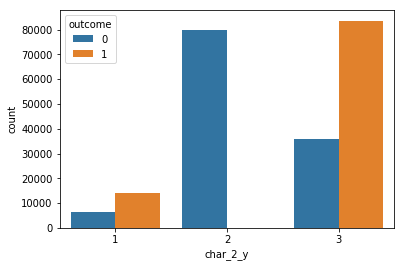

In [43]:
# randomforest importance가 높게 나옴
sns.countplot('char_2_y', hue='outcome', data=df_sample)
plt.show

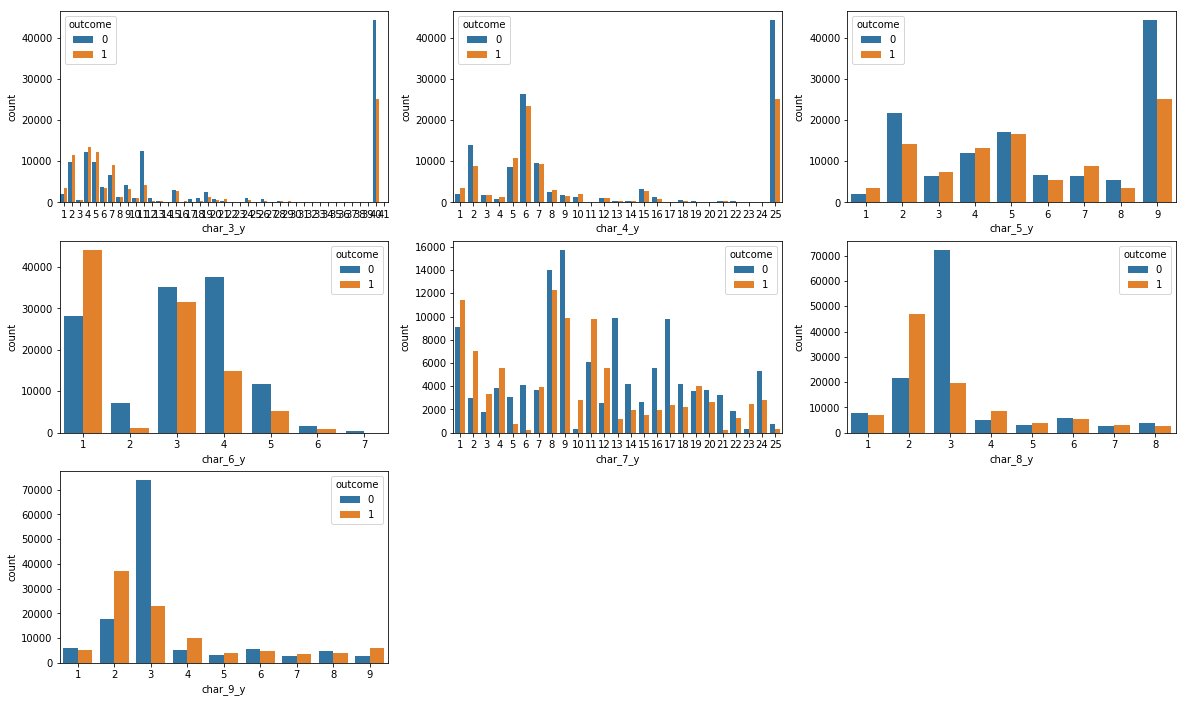

In [44]:
plt.figure(figsize=(20,12))
for i, feat in enumerate(df_sample.columns[list(df_sample).index('char_3_y'):list(df_sample).index('char_9_y')+1]):
    plt.subplot(3,3,i+1)
    sns.countplot(feat, hue='outcome', data=df_sample)
plt.show()

#### char_10_y ~ char_37

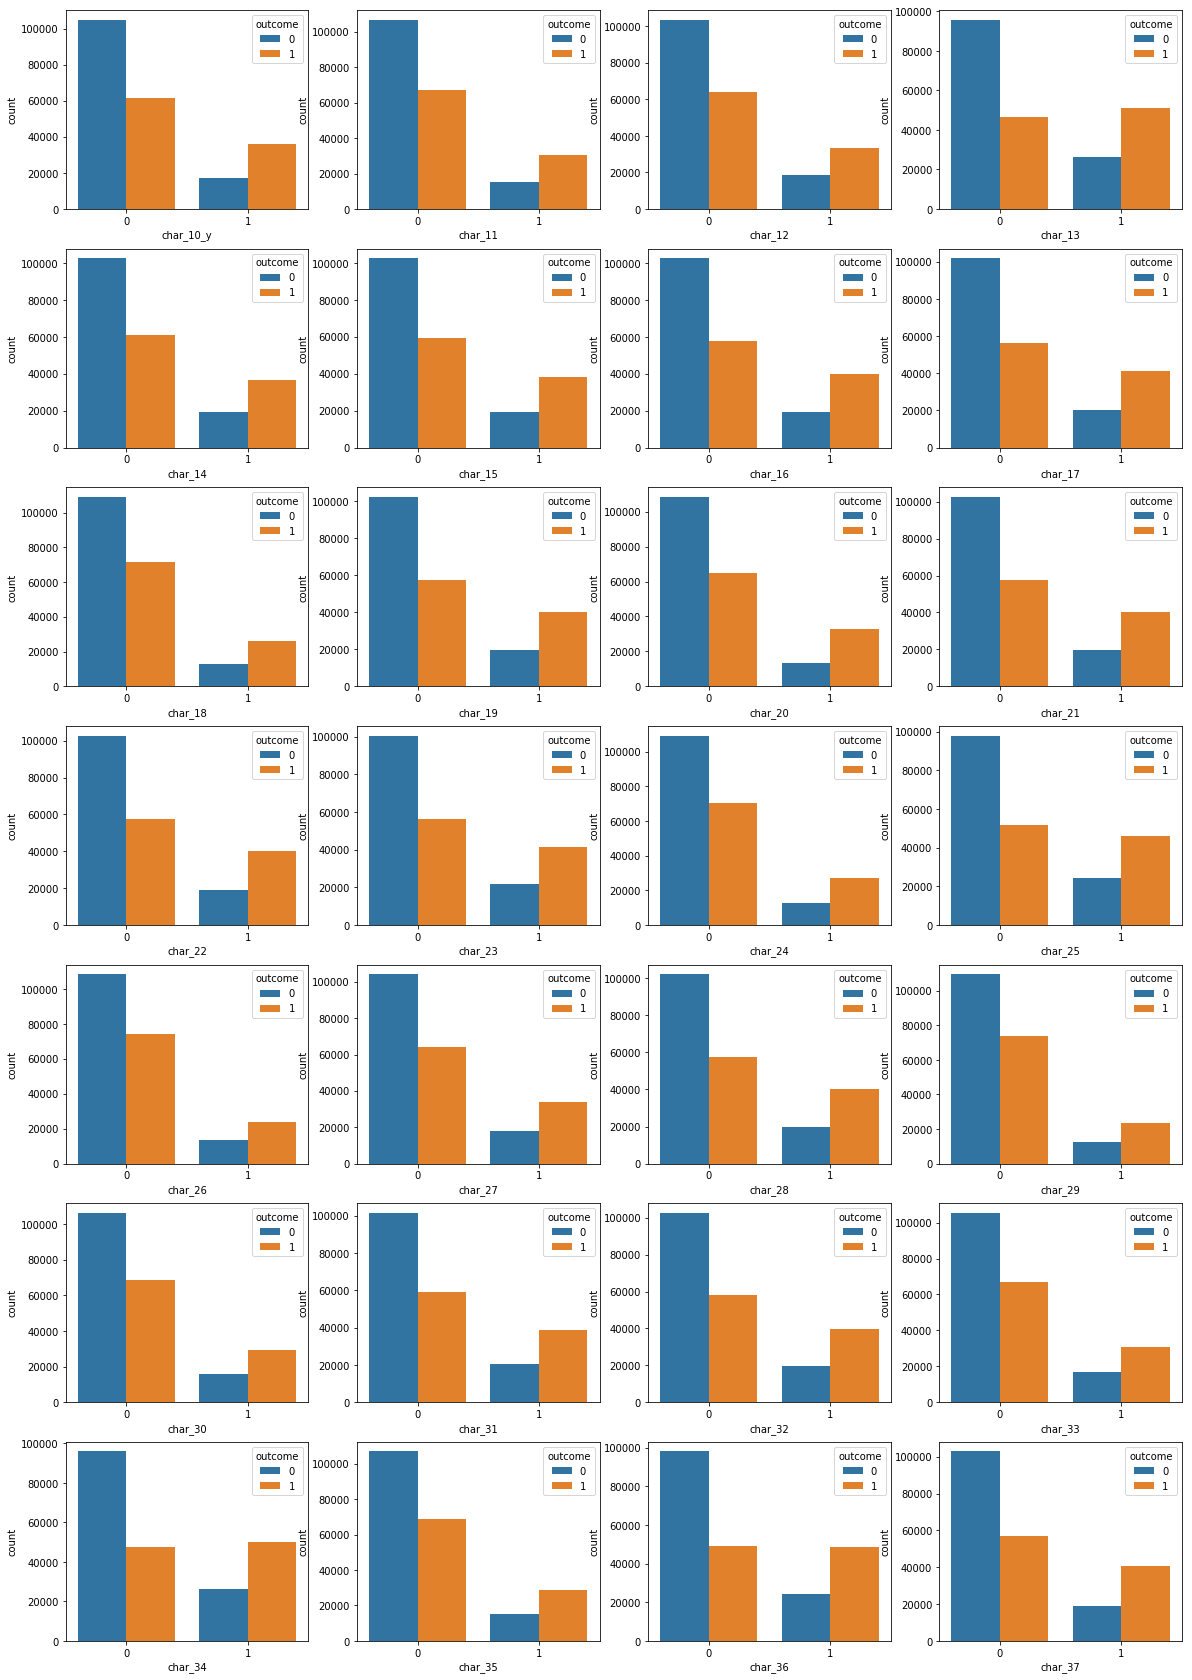

In [45]:
plt.figure(figsize=(20,30))
for i, feat in enumerate(df_sample.columns[list(df_sample).index('char_10_y'):list(df_sample).index('char_37')+1]):
    plt.subplot(7,4,i+1)
    sns.countplot(feat, hue='outcome', data=df_sample)
plt.show()

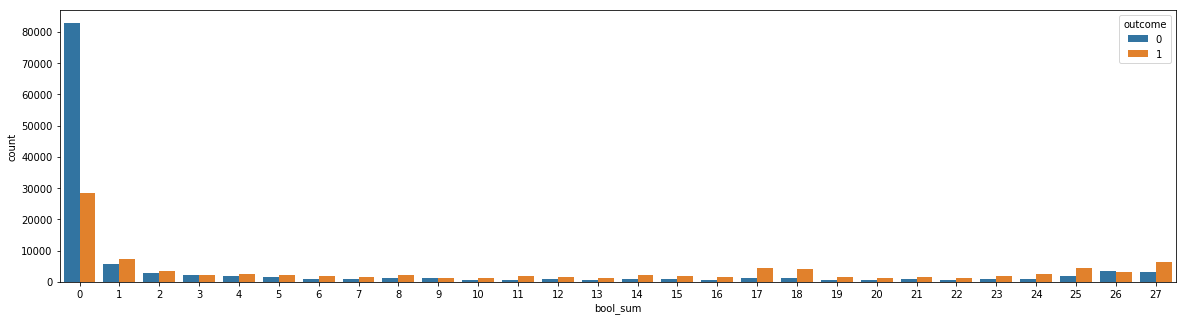

In [46]:
# bool변수들을 모두 합침
plt.figure(figsize=(20,5))
sns.countplot('bool_sum', hue='outcome', data=df_sample)
plt.show()

#### char_38

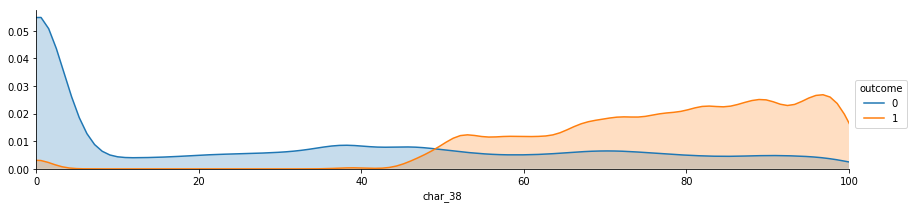

In [152]:
facet = sns.FacetGrid(df_sample, hue='outcome', aspect=4)
facet.map(sns.kdeplot, 'char_38', shade=True)
facet.set(xlim=(0, df_sample['char_38'].max()))
facet.add_legend()

plt.show()

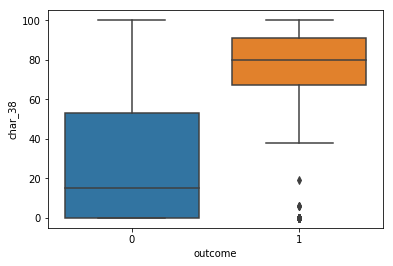

In [48]:
sns.boxplot(x="outcome", y="char_38", data=df_sample)
plt.show()

In [49]:
del df_sample, df_sample2

# feature selection

In [50]:
model1 = sm.OLS.from_formula("outcome ~ char_10_y + char_11 + char_12 + char_13 + char_14 + char_15 + char_16 + char_17 + char_18 + \
                            char_19 + char_20 + char_21 + char_22 + char_23 + char_24 + char_25 + char_26 + char_27 + char_28 + \
                            char_29 + char_30 + char_31 + char_32 + char_33 + char_34 + char_35 + char_36 + char_37", data=df_merge)
model2 = sm.OLS.from_formula("outcome ~ bool_sum", data=df_merge)
model3 = sm.OLS.from_formula("outcome ~ char_10_y + char_11 + char_12 + char_13 + char_14 + char_15 + char_16 + char_17 + char_18 + \
                            char_19 + char_20 + char_21 + char_22 + char_23 + char_24 + char_25 + char_26 + char_27 + char_28 + char_29 + \
                            char_30 + char_31 + char_32 + char_33 + char_34 + char_35 + char_36 + char_37 + bool_sum", data=df_merge)
result1 = model1.fit()
result2 = model2.fit()
result3 = model3.fit()

sm.stats.anova_lm(result1, result2, result3)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2197262.0,468586.705335,0.0,NaN,NaN,NaN
1,2197289.0,488060.609954,-27.0,-19473.904619,3382.053629,NaN
2,2197261.0,468587.211536,28.0,19473.398418,3261.181226,0.0


In [51]:
sm.stats.anova_lm(result1)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,df,sum_sq,mean_sq,F,PR(>F)
char_10_y,1.0,39255.800197,39255.800197,184075.384704,0.000000e+00
char_11,1.0,3274.086030,3274.086030,15352.601209,0.000000e+00
char_12,1.0,1346.035216,1346.035216,6311.728432,0.000000e+00
char_13,1.0,14478.788745,14478.788745,67892.861561,0.000000e+00
char_14,1.0,637.944548,637.944548,2991.402227,0.000000e+00
char_15,1.0,323.795202,323.795202,1518.316428,0.000000e+00
char_16,1.0,394.985645,394.985645,1852.137371,0.000000e+00
char_17,1.0,516.004010,516.004010,2419.607705,0.000000e+00
char_18,1.0,33.176989,33.176989,155.571077,1.053437e-35
char_19,1.0,11.868689,11.868689,55.653777,8.645827e-14


In [52]:
sm.stats.anova_lm(result2)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,df,sum_sq,mean_sq,F,PR(>F)
bool_sum,1.0,54360.208053,54360.208053,244734.12678,0.0
Residual,2197289.0,488060.609954,0.222119,NaN,NaN


In [53]:
sm.stats.anova_lm(result3)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,df,sum_sq,mean_sq,F,PR(>F)
char_10_y,1.0,39255.800197,39255.800197,184075.102078,0.000000e+00
char_11,1.0,3274.086030,3274.086030,15352.577637,0.000000e+00
char_12,1.0,1346.035216,1346.035216,6311.718741,0.000000e+00
char_13,1.0,14478.788745,14478.788745,67892.757319,0.000000e+00
char_14,1.0,637.944548,637.944548,2991.397635,0.000000e+00
char_15,1.0,323.795202,323.795202,1518.314097,0.000000e+00
char_16,1.0,394.985645,394.985645,1852.134527,0.000000e+00
char_17,1.0,516.004010,516.004010,2419.603990,0.000000e+00
char_18,1.0,33.176989,33.176989,155.570838,1.053564e-35
char_19,1.0,11.868689,11.868689,55.653691,8.646203e-14


# modeling

#### fillna(0)

In [54]:
df_merge.fillna(0, inplace=True)
df_merge_test.fillna(0, inplace=True)

#### columns

In [62]:
df_merge2 = one_hot_encoder(df_merge, ['activity_id', 'activity_category'])

In [63]:
df_merge_test2 = one_hot_encoder(df_merge_test, ['activity_id', 'activity_category'])

In [ ]:
a=['Past_days', 'activity_category', 'char_1_x', 'char_2_x', 'char_3_x', 'char_4_x', 'char_5_x', 'char_6_x', 'char_7_x', 'char_8_x', 'char_9_x', 'char_10_x', 'char_1_y', 'char_2_y', 'char_3_y', 'char_4_y', 'char_5_y', 'char_6_y', 'char_7_y', 'char_8_y', 'char_9_y', 'char_10_y', 'char_11', 'char_12', 'char_13', 'char_14', 'char_15', 'char_16', 'char_17', 'char_18', 'char_19', 'char_20', 'char_21', 'char_22', 'char_23', 'char_24', 'char_25', 'char_26', 'char_27', 'char_28', 'char_29', 'char_30', 'char_31', 'char_32', 'char_33', 'char_34', 'char_35', 'char_36', 'char_37', 'char_38']

In [135]:
a2=['activity_id1', 'activity_id2', 'Past_days', 'activity_category1', 'activity_category2', 'activity_category3', 'activity_category4', 'activity_category5', 'activity_category6', 'activity_category7', 'char_1_x', 'char_2_x', 'char_3_x', 'char_4_x', 'char_5_x', 'char_6_x', 'char_7_x', 'char_8_x', 'char_9_x', 'char_10_x', 'char_1_y', 'char_2_y', 'char_3_y', 'char_4_y', 'char_5_y', 'char_6_y', 'char_7_y', 'char_8_y', 'char_9_y', 'char_10_y', 'char_11', 'char_12', 'char_13', 'char_14', 'char_15', 'char_16', 'char_17', 'char_18', 'char_19', 'char_20', 'char_21', 'char_22', 'char_23', 'char_24', 'char_25', 'char_26', 'char_27', 'char_28', 'char_29', 'char_30', 'char_31', 'char_32', 'char_33', 'char_34', 'char_35', 'char_36', 'char_37', 'char_38', 'bool_sum']

In [136]:
a3=['activity_id1', 'activity_id2', 'Past_days', 'activity_category1', 'activity_category2', 'activity_category3', 'activity_category4', 'activity_category5', 'activity_category6', 'activity_category7', 'char_1_x', 'char_2_x', 'char_3_x', 'char_4_x', 'char_5_x', 'char_6_x', 'char_7_x', 'char_8_x', 'char_9_x', 'char_10_x', 'char_1_y', 'char_2_y', 'char_3_y', 'char_4_y', 'char_5_y', 'char_6_y', 'char_7_y', 'char_8_y', 'char_9_y', 'char_38', 'bool_sum']

## 나이브 베이즈

+ 가우시안 정규 분포 나이브 베이즈 모형

In [60]:
%%time
clf_norm = GaussianNB().fit(df_merge[a], df_merge.outcome)

Wall time: 15.4 s


In [61]:
%%time
cross_val_score(clf_norm, df_merge[a], df_merge.outcome, scoring="roc_auc", cv=10).mean()

Wall time: 1min 35s


0.80367149056196063

## 의사 결정 나무

In [62]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=10).fit(df_merge[a], df_merge.outcome)

In [63]:
cross_val_score(tree, df_merge[a], df_merge.outcome, scoring="roc_auc", cv=10).mean()

0.91260263415187737

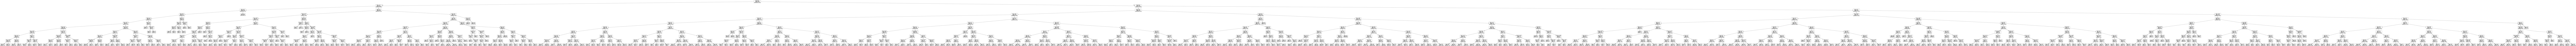

In [64]:
draw_decision_tree(tree, a)

## 랜덤 포레스트

+ RandomForestClassifier

In [92]:
rfc3 = RandomForestClassifier(n_estimators=30, max_depth=10).fit(df_merge2[a3], df_merge2.outcome)

In [96]:
%%time
cross_val_score(rfc3, df_merge2[a3], df_merge2.outcome, scoring="roc_auc", cv=10).mean() #0.85

Wall time: 11min 38s


0.91472488029768795

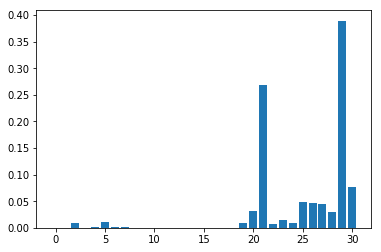

In [93]:
importance = rfc3.feature_importances_
importance = pd.DataFrame(importance, index=df_merge2.loc[:,a3].columns, 
                          columns=["Importance"])
importance["Std"] = np.std([tree.feature_importances_ for tree in rfc3.estimators_], axis=0)
x = range(importance.shape[0])
y = importance.iloc[:, 0]
yerr = importance.iloc[:, 1]
plt.bar(x, y)
plt.show()

In [266]:
importance.sort_values(by='Importance', ascending=False).head()

,Importance,Std
char_38,0.389525,0.236211
char_2_y,0.268241,0.208562
bool_sum,0.077494,0.099533
char_6_y,0.048938,0.036268
char_7_y,0.046434,0.017933


In [ ]:
# df_submission = pd.DataFrame({'activity_id' : df_test_act_id, 'outcome' : rfc3.predict(df_merge_test2[a3])}).set_index('activity_id')
# df_submission.to_csv("df_submission_rfc.csv")

+ ExtraTreesClassifier

In [214]:
%%time
efc = ExtraTreesClassifier(n_estimators=30, max_depth=10).fit(df_merge2[a3], df_merge2.outcome)

Wall time: 58.3 s


In [215]:
%%time
cross_val_score(efc, df_merge2[a3], df_merge2.outcome, scoring="roc_auc", cv=10).mean()

Wall time: 7min 52s


0.90707693877878959

In [218]:
# df_submission = pd.DataFrame({'activity_id' : df_test_act_id, 'outcome' : efc.predict(df_merge_test2[a3])}).set_index('activity_id')
# df_submission.to_csv("df_submission_efc.csv")

# xgboost

In [216]:
%%time
xgb = xgboost.XGBClassifier(n_estimators=30, max_depth=10).fit(df_merge2[a3], df_merge2.outcome)

Wall time: 3min 4s


In [217]:
%%time
# kaggle : 0.92
cross_val_score(xgb, df_merge2[a3], df_merge2.outcome, scoring="roc_auc", cv=10).mean()

Wall time: 23min 54s


0.9055280587022484

In [230]:
# df_submission = pd.DataFrame({'activity_id' : df_test_act_id, 'outcome' : pd.DataFrame(xgb.predict_proba(df_merge_test2[a3])).loc[:,1]}).set_index('activity_id')
# df_submission.to_csv("df_submission_xgb121.csv")

# H2O

In [102]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.151-b12, mixed mode)
  Starting server from C:\ProgramData\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\kwon\AppData\Local\Temp\tmp6n_uvt0l
  JVM stdout: C:\Users\kwon\AppData\Local\Temp\tmp6n_uvt0l\h2o_kwon_started_from_python.out
  JVM stderr: C:\Users\kwon\AppData\Local\Temp\tmp6n_uvt0l\h2o_kwon_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,10 secs
H2O cluster version:,3.14.0.7
H2O cluster version age:,1 month
H2O cluster name:,H2O_from_python_kwon_3ob3xl
H2O cluster total nodes:,1
H2O cluster free memory:,891 Mb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"
H2O connection url:,http://127.0.0.1:54321
H2O connection proxy:,None


In [84]:
coltype_dict = dict()
ignore_list = ['people_id', 'activity_id', 'group_1', 'char_10_x']
numeric_list = ['char_38', 'bool_sum', 'days', 'Past_days']
date_list = ['date_x', 'date_y']
for col in list(df_merge):
    type_ = 'string'
    if col in ignore_list:
        type_ = 'string'
    elif col in numeric_list:
        type_ = 'numeric'
    elif col in date_list:
        type_ = 'time'
    else:
        type_ = 'enum'
    coltype_dict[col] = type_
print(coltype_dict)
print()

na_dict = dict()
na_list = ['char_{}_x'.format(x) for x in range(1, 10)]
for item in na_list:
    na_dict[item] = ['0']
print(na_dict)

{'people_id': 'string', 'activity_id': 'string', 'date_x': 'time', 'week_x': 'enum', 'Past_days': 'numeric', 'activity_category': 'enum', 'char_1_x': 'enum', 'char_2_x': 'enum', 'char_3_x': 'enum', 'char_4_x': 'enum', 'char_5_x': 'enum', 'char_6_x': 'enum', 'char_7_x': 'enum', 'char_8_x': 'enum', 'char_9_x': 'enum', 'char_10_x': 'string', 'outcome': 'enum', 'char_1_y': 'enum', 'group_1': 'string', 'char_2_y': 'enum', 'date_y': 'time', 'week_y': 'enum', 'char_3_y': 'enum', 'char_4_y': 'enum', 'char_5_y': 'enum', 'char_6_y': 'enum', 'char_7_y': 'enum', 'char_8_y': 'enum', 'char_9_y': 'enum', 'char_10_y': 'enum', 'char_11': 'enum', 'char_12': 'enum', 'char_13': 'enum', 'char_14': 'enum', 'char_15': 'enum', 'char_16': 'enum', 'char_17': 'enum', 'char_18': 'enum', 'char_19': 'enum', 'char_20': 'enum', 'char_21': 'enum', 'char_22': 'enum', 'char_23': 'enum', 'char_24': 'enum', 'char_25': 'enum', 'char_26': 'enum', 'char_27': 'enum', 'char_28': 'enum', 'char_29': 'enum', 'char_30': 'enum', 'c

In [85]:
%%time
hf_merge1 = h2o.H2OFrame(df_merge , column_types=coltype_dict, na_strings=na_dict)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Wall time: 3min 34s


In [86]:
%%time
rf_v1 = H2ORandomForestEstimator(
    model_id="rf_covType_v1",
    ntrees=100,
    max_depth=15,
    stopping_rounds=2,
    score_each_iteration=True,
    seed=1000000)

Wall time: 6 ms


In [87]:
%%time
rf_v1.train(a, 'outcome', training_frame=hf_merge1)

drf Model Build progress: |███████████████████████████████████████████████| 100%
Wall time: 11min 21s


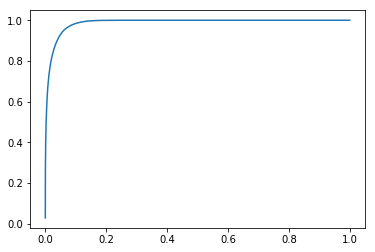

Wall time: 768 ms


In [88]:
%%time
roc = rf_v1.roc()

plt.plot(roc[0], roc[1])
plt.show()

In [268]:
rf_v1.varimp(use_pandas = True)

NameError: name 'rf_v1' is not defined

In [269]:
coltype_dict = dict()
ignore_list = ['people_id', 'activity_id', 'group_1', 'char_10_x']
numeric_list = ['char_38', 'bool_sum', 'days', 'Past_days']
date_list = ['date_x', 'date_y']
for col in list(df_merge_test):
    type_ = 'string'
    if col in ignore_list:
        type_ = 'string'
    elif col in numeric_list:
        type_ = 'numeric'
    elif col in date_list:
        type_ = 'time'
    else:
        type_ = 'enum'
    coltype_dict[col] = type_

In [90]:
%%time
hf_merge1_test = h2o.H2OFrame(df_merge_test , column_types=coltype_dict, na_strings=na_dict)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Wall time: 37 s


In [91]:
rf_v1_predict = rf_v1.predict(hf_merge1_test[a])

drf prediction progress: |████████████████████████████████████████████████| 100%


In [92]:
rf_v1.varimp(use_pandas = True)

,variable,relative_importance,scaled_importance,percentage
0,char_38,2.569517e+06,1.000000,0.307606
1,char_2_y,1.618235e+06,0.629782,0.193724
2,char_7_y,6.475879e+05,0.252027,0.077525
3,char_8_y,5.926612e+05,0.230651,0.070949
4,char_9_y,4.544932e+05,0.176879,0.054409
5,char_6_y,2.672119e+05,0.103993,0.031989
6,char_3_y,2.584462e+05,0.100582,0.030939
7,char_4_y,2.008261e+05,0.078157,0.024042
8,char_34,1.937194e+05,0.075391,0.023191
9,Past_days,1.337614e+05,0.052057,0.016013


In [93]:
rf_v1_predict_df = rf_v1_predict[['predict', 'p0', 'p1']].as_data_frame()

In [94]:
df_submission_h2o = pd.DataFrame({'activity_id' : df_test_act_id, 
                              'outcome1' : rf_v1_predict_df['p1']
                             })

In [96]:
df_sub = pd.merge(df_submission_h2o, df_gd_test, on='activity_id')

In [97]:
df_sub = df_sub.rename(index=str, columns={"outcome": "outcome2"})

In [98]:
df_sub['outcome']=np.nan

In [99]:
df_sub.loc.__setitem__((df_sub.loc[:,'outcome2'].isnull()==False, ('outcome')), df_sub['outcome2'])

In [100]:
df_sub.loc.__setitem__((df_sub.loc[:,'outcome2'].isnull(), ('outcome')), df_sub['outcome1'])

In [101]:
df_submission_gd = pd.DataFrame({'activity_id' : df_sub.activity_id,
                                 'outcome' : df_sub.outcome
                                }).set_index('activity_id')

In [102]:
# df_submission_gd.to_csv("df_submission_gd2.csv")

# group & days

In [ ]:
df_gd = df_merge.loc[:, ['group_1', 'days', 'outcome']].copy()

In [ ]:
df_gd_test = pd.DataFrame({'activity_id' : df_test_act_id, 'group_1' : df_merge_test.group_1, 'days' : df_merge_test['days'], 'outcome':np.nan})         

In [ ]:
%%time
gp_0 = []; gp_1 = []; gp_01= []
for gp in df_gd.group_1.unique():
    if len(df_gd[df_gd.group_1==gp].loc[:,'outcome'].unique()) == 1:
        if df_gd[df_gd.group_1==gp].loc[:,'outcome'].iloc[0]:
            gp_1.append(gp)
        else:
            gp_0.append(gp)
    else :
        gp_01.append(gp)

In [ ]:
%%time
gp_0_test = []; gp_1_test = []; gp_01_test= []; gp_nan_test = []
for col in df_gd_test.group_1.unique():
    if col in gp_0:
        gp_0_test.append(col)
    elif col in gp_1:
        gp_1_test.append(col)
    elif col in gp_01:
        gp_01_test.append(col)
    else :
        gp_nan_test.append(col)

In [ ]:
plt.figure(figsize=(25,20))
for i in range(5):
    plt.subplot(5,1,i+1) 
    plt.plot(np.array(df_gd[df_gd.loc[:,'group_1']==gp_01[i]]['days'].sort_values().drop_duplicates()), np.array(df_gd.loc[df_gd[df_gd.loc[:,'group_1']==gp_01[i]]['days'].sort_values().drop_duplicates().index].outcome))
    plt.plot(np.array(df_gd[df_gd.loc[:,'group_1']==gp_01[i]]['days'].sort_values().drop_duplicates()), np.ones(len(np.array(df_gd[df_gd.loc[:,'group_1']==gp_01[i]]['days'].sort_values().drop_duplicates())))/2)
    plt.ylim(-0.1,1.1)
plt.show()

In [ ]:
%%time
gp_dict = dict()
for gp in gp_01_test:
    gp_dict[gp] = []
    temp = df_gd[df_gd.group_1==gp].loc[:,['days','outcome']].sort_values(by=['days'])
    for i in range(len(df_gd[df_gd.group_1==gp])-1):
        if temp.iloc[i].outcome - temp.iloc[i+1].outcome == 1:
            gp_dict[gp].append(temp.iloc[i].days)
            gp_dict[gp].append(temp.iloc[i+1].days)
        elif temp.iloc[i].outcome - temp.iloc[i+1].outcome == -1:
            gp_dict[gp].append(-temp.iloc[i].days)
            gp_dict[gp].append(temp.iloc[i+1].days)
        else:
            pass

In [ ]:
df_gd_test.loc.__setitem__((df_gd_test.loc[:,'group_1'].isin(gp_0_test), ('outcome')), 0)

In [ ]:
df_gd_test.loc.__setitem__((df_gd_test.loc[:,'group_1'].isin(gp_1_test), ('outcome')), 1)

In [ ]:
%%time
idx_list = df_gd_test[df_gd_test.loc[:,'group_1'].isin(gp_01_test)].loc[:,'group_1'].index
df_gp01_test = df_gd_test[df_gd_test.loc[:,'group_1'].isin(gp_01_test)]
gp_series = df_gp01_test.loc[:,'group_1']
days_series = df_gp01_test.loc[:,'days']


for idx in idx_list:
    gp_list = gp_dict[gp_series.loc[idx]]
    day = days_series.loc[idx]
    if len(gp_list)==4:
        if gp_list[0] < 0 :
            if (abs(gp_list[0]) > day) or (abs(gp_list[3]) < day):
                df_gd_test.loc.__setitem__((idx, ('outcome')), 0)
            elif (abs(gp_list[0]) < day < abs(gp_list[1])):
                df_gd_test.loc.__setitem__((idx, ('outcome')), ((day - abs(gp_list[0])) / (abs(gp_list[1]) - abs(gp_list[0]))))
            elif (abs(gp_list[2]) < day < abs(gp_list[3])):
                df_gd_test.loc.__setitem__((idx, ('outcome')), (abs(gp_list[3]) - day) / (abs(gp_list[3]) - abs(gp_list[2])))
            else : 
                df_gd_test.loc.__setitem__((idx, ('outcome')), 1)
        else :
            if (abs(gp_list[0]) > day) or (abs(gp_list[3]) < day):
                df_gd_test.loc.__setitem__((idx, ('outcome')), 1)
            elif (abs(gp_list[0]) < day < abs(gp_list[1])):
                df_gd_test.loc.__setitem__((idx, ('outcome')), (abs(gp_list[1]) - day) / (abs(gp_list[1]) - abs(gp_list[0])))
            elif (abs(gp_list[2]) < day < abs(gp_list[3])):
                df_gd_test.loc.__setitem__((idx, ('outcome')), (day - abs(gp_list[2])) / (abs(gp_list[3]) - abs(gp_list[2])))
            else : 
                df_gd_test.loc.__setitem__((idx, ('outcome')), 0)
    else :
        if gp_list[0] < 0 :
            if abs(gp_list[0]) > day:
                df_gd_test.loc.__setitem__((idx, ('outcome')), 0)
            elif abs(gp_list[1]) < day: 
                df_gd_test.loc.__setitem__((idx, ('outcome')), 1)
            else :
                df_gd_test.loc.__setitem__((idx, ('outcome')), (day - abs(gp_list[1])) / (abs(gp_list[1]) - abs(gp_list[0])))
        else :
            if abs(gp_list[0]) > day:
                df_gd_test.loc.__setitem__((idx, ('outcome')), 1)
            elif abs(gp_list[1]) < day: 
                df_gd_test.loc.__setitem__((idx, ('outcome')), 0)
            else:
                df_gd_test.loc.__setitem__((idx, ('outcome')), (abs(gp_list[1]) - day) / (abs(gp_list[1]) - abs(gp_list[0])))      